In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import selfies as sf
import counterstone as cs
import warnings
from rdkit import Chem
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)

hivdata = pd.read_csv('HIV.csv')

/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#shuffle rows and sample fom HIV dataset
hivdata = hivdata.sample(frac=1).reset_index(drop=True)
hivdata.head()

,smiles,activity,HIV_active
0,COc1c2occc2c(N=Cc2c[nH]c3ccccc23)c2ccc(=O)oc12,CI,0
1,O=[N+]([O-])c1cccc(C2=NOC(C3CCCCC3)C2)c1,CI,0
2,CC(=O)CCC(=O)CC(O)(C(F)(F)F)C(F)(F)F,CI,0
3,N#CC1(Cc2ccccc2Cl)c2ccccc2C=CN1C(=O)c1ccccc1,CI,0
4,COc1c(Cl)cc(C(=CCCC2CCC3(C)C(CCC4C3CCC3(C)C(C(...,CA,1


In [3]:
def gen_smiles2graph(sml):
    '''Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    '''
    m, smi_canon,status = cs.stoned.sanitize_smiles(sml)
    #m = Chem.MolFromSmiles(smi_canon)
    m = Chem.AddHs(m)
    order_string = {Chem.rdchem.BondType.SINGLE: 1,
                    Chem.rdchem.BondType.DOUBLE: 2,
                    Chem.rdchem.BondType.TRIPLE: 3,
                    Chem.rdchem.BondType.AROMATIC: 4}
    N = len(list(m.GetAtoms()))
    #nodes = np.zeros((N,100))
    nodes = np.zeros((400,100))
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1
    
    #adj = np.zeros((N,N))
    adj = np.zeros((400,400))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(),j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(),j.GetEndAtomIdx())        
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning('Ignoring bond order' + order)
        adj[u, v] = 1        
        adj[v, u] = 1
    adj += np.eye(400)
    return nodes, adj

In [4]:
class GCNLayer(tf.keras.layers.Layer):
    '''Implementation of GCN as layer'''
    def __init__(self, activation=None,**kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]),
                                name='w')
        
    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs 
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum('bi,bij,bjk,kl->bil', 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj


In [5]:
class GRLayer(tf.keras.layers.Layer):
    '''Reduction layer: A GNN layer that computes average over all node features'''
    def __init__(self, name='GRLayer', **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)
    
    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction

In [6]:
ninput = tf.keras.Input((None,100,))
ainput = tf.keras.Input((None,None,))
# GCN block
x = GCNLayer('relu')([ninput, ainput])
x = GCNLayer('relu')(x)
x = GCNLayer('relu')(x)
x = GCNLayer('relu')(x)
# reduce to graph features
x = GRLayer()(x)
# standard layers
#x = tf.keras.layers.Flatten()
x = tf.keras.layers.Dense(256, 'tanh')(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
gcnmodel = tf.keras.Model(inputs=(ninput, ainput), outputs=x)
gcnmodel.compile('adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
gcnmodel.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
gcn_layer (GCNLayer)            ((None, None, 100),  10000       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
gcn_layer_1 (GCNLayer)          ((None, None, 100),  10000       gcn_layer[0][0]       

In [7]:
def gen_data():
    for i in range(len(hivdata)):
        graph = gen_smiles2graph(hivdata.smiles[i])        
        activity = hivdata.HIV_active[i]
        yield graph, activity
data = tf.data.Dataset.from_generator(gen_data, output_types=((tf.float32, tf.float32), tf.float32), 
                                      output_shapes=((tf.TensorShape([None, 100]), tf.TensorShape([None, None])), tf.TensorShape([])))

In [10]:
N = len(hivdata)
split = int(0.1 * N)
test_data = data.take(split)
nontest = data.skip(split)
val_data, train_data = nontest.take(split), nontest.skip(split).shuffle(1000)

In [9]:
%%time
result = gcnmodel.fit(train_data.batch(64), validation_data=val_data.batch(64),  epochs=20, verbose=0)

CPU times: user 4min 51s, sys: 31.4 s, total: 5min 22s
Wall time: 5min 21s


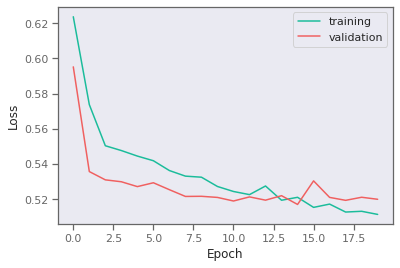

In [11]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

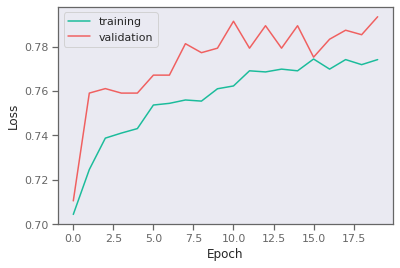

In [12]:
plt.plot(result.history['accuracy'], label='training')
plt.plot(result.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [13]:
prediction = []
test_y = []
for x,y in test_data.as_numpy_iterator():
    yhat = gcnmodel((x[0][np.newaxis,...], x[1][np.newaxis,...]))
    prediction.append(yhat.numpy())
    test_y.append(y)

prediction = np.array(prediction).flatten()
test_y = np.array(test_y)

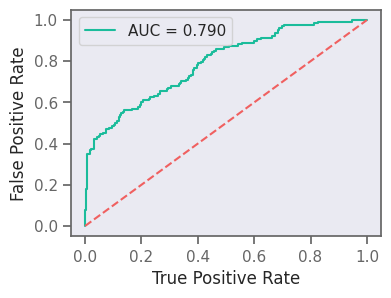

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
#y_pred_keras = gcnmodel.predict(test_data).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, prediction)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(figsize=(4,3), dpi=100)
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend()
plt.show()

## CF explanation

The following example find CFs for a given molecule where the HIV activity is zero.

In [15]:
def predictor_function(smiles,selfies):
    #print('inut:',smiles)
    labels = []
    for sml in smiles:
        nodes, adj_mat = gen_smiles2graph(sml)
        pred = gcnmodel((nodes[np.newaxis,...], adj_mat[np.newaxis,...])).numpy()
        labels.append(pred)
        
    labels = np.array(labels).flatten()   
    target_act = np.zeros(len(labels))
    return abs(target_act-labels)<0.2

In [17]:
sml_list = list(hivdata.smiles)
space = cs.sample_space(sml_list[1], predictor_function)

STONED Round Complete with 1500
STONED Round Complete with 1500


In [18]:
exps = cs.counterfactual_explain(space)
print(exps)

[Examples(smiles='O=[N+]([O-])c1cccc(C2=NOC(C3CCCCC3)C2)c1', selfies='[O][=N+expl][Branch1_1][C][O-expl][C][=C][C][=C][C][Branch2_1][Ring1][C][C][=N][O][C][Branch1_1][Branch2_2][C][C][C][C][C][C][Ring1][Branch1_2][C][Ring1][O][=C][Ring1][P]', similarity=1.0, yhat=True, index=0, position=array([8.87117137, 1.39580411]), is_origin=True, cluster=-1, label=None), Examples(smiles='N[N+]([O-])c1cccc(C2=NOC(C3CCCCC3)C2)c1', selfies='[N][N+expl][Branch1_1][C][O-expl][C][=C][C][=C][C][Branch2_1][Ring1][C][C][=N][O][C][Branch1_1][Branch2_2][C][C][C][C][C][C][Ring1][Branch1_2][C][Ring1][O][=C][Ring1][P]', similarity=0.8412698412698413, yhat=False, index=27, position=array([6.95545925, 0.32082246]), is_origin=False, cluster=9, label='Counterfactual 1'), Examples(smiles='NO[N+]([O-])c1cccc(C2=NOC(C3CCCCC3)C2)c1', selfies='[N][O][N+expl][Branch1_1][C][O-expl][C][=C][C][=C][C][Branch2_1][Ring1][C][C][=N][O][C][Branch1_1][Branch2_2][C][C][C][C][C][C][Ring1][Branch1_2][C][Ring1][O][=C][Ring1][P]', simi

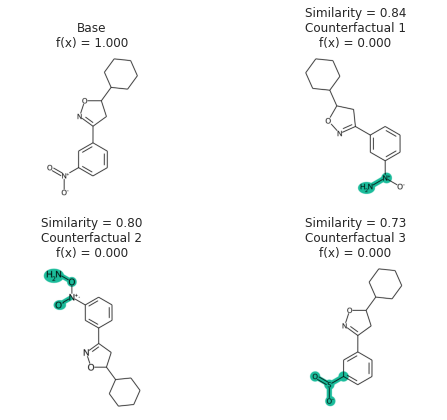

In [19]:
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
cs.plot_explanation(exps, figure_kwargs=fkw, mol_size=(450,400))
plt.savefig('gnn-CFs.png', dpi=180)

TypeError: __init__() got an unexpected keyword argument 'alpha'

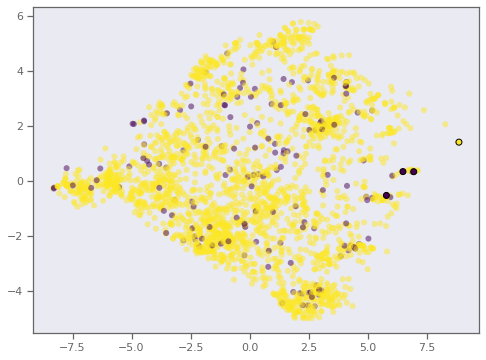

In [20]:
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

cs.plot_space(space, exps, figure_kwargs=fkw, mol_size=(350,300))
plt.scatter([], [], label='Counterfactual', s=150, color=plt.get_cmap('viridis')(1.0))
plt.scatter([], [], label='Same Label', s=150, color=plt.get_cmap('viridis')(0.0))
plt.legend(fontsize=22)
plt.savefig('gnn-space.png', bbox_inches='tight', dpi=180)